In [248]:
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import os



In [250]:
# Load the CSV file
path='/home/g/g300047/SCRIPTS/github/heat-indicators-africa/data_wascal_ts'
file_name='climdexCORDEX_TG_year_weighted_means.csv'
file_path = os.path.join(path,file_name)
data = pd.read_csv(file_path)
outputpath='/work/ch0636/g300047/cicles/timeseries_plots_bulletin'


In [251]:
# adjust dataframe for plotting
# drop column ci_package_name
_data = data.drop(columns=['ci_package_name', 'ci_package_reference'])
# rename columns
_data = _data.rename(columns={'time': 'year', 'value': 'mean temperature [K]'})
_data['mean temperature [°C]'] = _data['mean temperature [K]'] - 273.15

#some neu columns
_data['GCM'] = _data['realization'].str.split('_').str[3]
_data['region'] = _data['realization'].str.split('_').str[0]
_data['RCM'] = _data['realization'].str.split('_').str[2]
_data['scenario'] = _data['realization'].str.split('_').str[4]
_data['year'] = pd.to_datetime(_data['year'], format='%Y-%m-%d')
_data[:2]

,realization,year,region,mean temperature [K],ci_name,ci_frequency,standard_name,units,mean temperature [°C],GCM,RCM,scenario
0,AFR-22_GERICS_CLMcom-KIT-CCLM5-0-15_MOHC-HadGE...,1950-07-15,AFR-22,298.17273,TG,year,air_temperature,K,25.02273,MOHC-HadGEM2-ES,CLMcom-KIT-CCLM5-0-15,rcp26
1,AFR-22_GERICS_CLMcom-KIT-CCLM5-0-15_MOHC-HadGE...,1951-07-15,AFR-22,298.40036,TG,year,air_temperature,K,25.25036,MOHC-HadGEM2-ES,CLMcom-KIT-CCLM5-0-15,rcp26


In [252]:
# Some names need fixing: rename RCMs // GCMs
_data['RCM'] = _data['RCM'].replace({'ICTP-RegCM4-7-0ICTP-RegCM4-7': 'ICTP-RegCM4-7'})
_data['GCM'] = _data['GCM'].replace({'MPI-M-MPI-ESM-MRMPI-M-MPI-ESM-MR': 'MPI-M-MPI-ESM-MR',
                                     'NCC-NorESM1-MNCC-NorESM1-M': 'NCC-NorESM1-M',})


In [253]:
def line_plot(data,x,y,explore, outputpath):
    print(explore)
    # Define unique styles
    colors = ['darkblue', 'darkred','green', 'orange', 'purple', 'brown', 'pink']
    marker_styles = ['o', 'x', '^']
    line_styles = ['-', ':', '--',':']
    # Create unique mappings
    scenarios = data['scenario'].unique()
    gcms = data['GCM'].unique()
    rcms = data['RCM'].unique()
    plt.figure(figsize=(12, 8))
    
    if explore =='GCMcolor': 
        color_map = dict(zip(gcms, colors))
        linestyle_map = dict(zip(scenarios, line_styles))
        marker_map = dict(zip(rcms, marker_styles))
        for (scenario, gcm, rcm), group in data.groupby(['scenario', 'GCM', 'RCM']):
            plt.plot(
                group[x], group[y],
                label=f'{scenario} | {gcm} | {rcm}',
                color=color_map[gcm],
                linestyle=linestyle_map[scenario],
                marker=None,
                alpha=0.5,
                markersize=4,
                linewidth=2
            )

    elif explore =='RCMcolor':
        color_map = dict(zip(rcms, colors))
        linestyle_map = dict(zip(scenarios, line_styles))
        marker_map = dict(zip(rcms, marker_styles))
        for (scenario, gcm, rcm), group in data.groupby(['scenario', 'GCM', 'RCM']):
            plt.plot(
                group[x], group[y],
                label=f'{scenario} | {gcm} | {rcm}',
                color=color_map[rcm],
                linestyle=linestyle_map[scenario],
                marker=None,
                alpha=0.5,
                markersize=4,
                linewidth=1.5
                )

    elif explore =='Scenario':
        color_map = dict(zip(scenarios, colors))
        linestyle_map = dict(zip(gcms, line_styles))
        marker_map = dict(zip(rcms, marker_styles))
    
    # Create the plot
        
        for (scenario, gcm, rcm), group in data.groupby(['scenario', 'GCM', 'RCM']):
            plt.plot(
                group[x], group[y],
                label=f'{scenario} | {gcm} | {rcm}',
                color=color_map[scenario],
                linestyle=linestyle_map[gcm],
                marker=marker_map[rcm],
                alpha=0.5,
                markersize=4,
                linewidth=1
            )
    else:
        raise ValueError("Invalid value for 'explore'. Must be 'GCM', 'RCM', or 'Scenario'.")
    
    plt.title('WASCAL Region Area Mean Temperature')
    plt.legend(title='CORDEX AFR22 Realization', loc='upper left', ncol=1, fontsize=8)
    plt.tight_layout()
    plt.xticks(rotation=0)
    plt.xlabel(x)
    plt.ylabel(y)
    # rename x and y for plotname
    x=x.replace(' ', '_')
    y=y.replace(' ', '_')
    # save plot
    outfile = os.path.join(outputpath,'line_plot_'+x+'_'+y+'_'+explore+'.png')
    plt.savefig(outfile, dpi=300)
    
    
    return plt.show()


Scenario


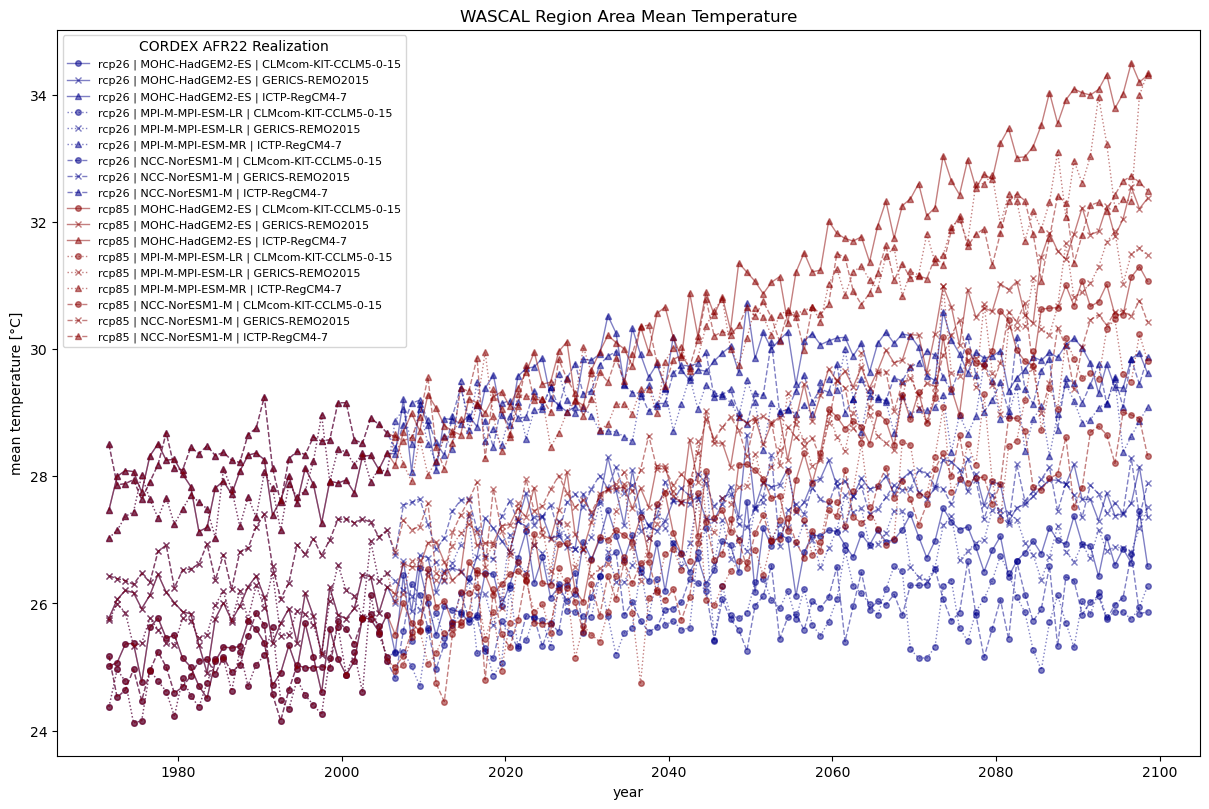

In [254]:
#cut out 1971-2098

cut_data = _data[_data['year'] >= pd.Timestamp('1971-01-01')]
cut_data = cut_data[cut_data['year'] <= pd.Timestamp('2098-12-31')]

# make plot
line_plot(cut_data,'year', 'mean temperature [°C]','Scenario', outputpath)


In [256]:
# Mean over 1991-2024 and calculate the anomalies
# time mean for each realization from 1991-2024
# Filter the DataFrame by year
df= cut_data.copy()
df['year'] = pd.to_datetime(df['year'], format='%Y-%m-%d').dt.year
df_filtered = df[(df['year'] >= 1991) & (df['year'] <= 2024)]

# Group by realization and calculate the mean
mean_per_realization = df_filtered.groupby('realization')['mean temperature [°C]'].mean().reset_index()
mean_per_realization.rename(columns={'mean temperature [°C]': 'mean 1991-2024'}, inplace=True)


In [258]:
# Merge the means back to the original DataFrame
df['mean 1991-2024'] = df['realization'].map(mean_per_realization.set_index('realization')['mean 1991-2024'])
# Calculate the anomalies
# Subtract the mean to get anomalies
df['Temperature [K] anomaly to [1991-2024]'] = df['mean temperature [°C]'] - df['mean 1991-2024']

# running mean
# Calculate the running mean
# Sort the DataFrame by realization and year
df = df.sort_values(['realization', 'year'])

# Apply a 10-year/30-year running mean per realization
df['running_mean_10yr'] = (
    df.groupby('realization')['Temperature [K] anomaly to [1991-2024]']
    .transform(lambda x: x.rolling(window=10, min_periods=10).mean())
)

df['running_mean_30yr'] = (
    df.groupby('realization')['Temperature [K] anomaly to [1991-2024]']
    .transform(lambda x: x.rolling(window=30, min_periods=30).mean())
)

In [ ]:
def line_plot_anomaly(data,x,y,outputpath):
    # Define unique styles
    print(data.columns)
    colors = ['darkblue', 'darkred']
    marker_styles = ['o', 'x', '^']
    line_styles = ['-', ':', '--',':']
    # Create unique mappings
    scenarios = data['scenario'].unique()
    gcms = data['GCM'].unique()
    rcms = data['RCM'].unique()
    plt.figure(figsize=(12, 8))
    
    color_map = dict(zip(scenarios, colors))
    linestyle_map = dict(zip(gcms, line_styles))
    marker_map = dict(zip(rcms, marker_styles))
    # Create the plot
        
    for (scenario, gcm, rcm), group in data.groupby(['scenario', 'GCM', 'RCM']):
        plt.plot(
            group[x], group[y],
            label=f'{scenario} | {gcm} | {rcm}',
            color=color_map[scenario],
            linestyle=linestyle_map[gcm],
            marker=marker_map[rcm],
            alpha=0.5,
            markersize=4,
            linewidth=1
        )
        
    plt.title('Area Mean of WASCAL Region', fontsize=16)
    plt.legend(title='CORDEX AFR22 Realization', loc='upper left', ncol=1, fontsize=8)
    plt.tight_layout()
    plt.xticks(rotation=0)
    plt.xlabel(x, fontsize=14)
    plt.ylabel(y, fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.ylim(-2, 6)
    plt.xlim(1971, 2100)
    plt.axhline(0, color='grey', linestyle='-', linewidth=1)
    plt.axvline(1991, color='grey', linestyle='-', linewidth=1)
    plt.axvline(2024, color='grey', linestyle='-', linewidth=1)
    # Fill between the vertical lines for the reference period
    plt.fill_betweenx(
        y=plt.ylim(), 
        x1=1991, 
        x2=2024, 
        color='grey', 
        alpha=0.1
    )
    # Add a legend for the shaded area
    plt.text(1993, -1.7, 'Reference Period (1991-2024)', color='grey', fontsize=12)
    # rename x and y for plotname
    x=x.replace(' ', '_')
    y=y.replace(' ', '_')
    # save plot
    outfile = os.path.join(outputpath,'line_plot_'+x+'_'+y+'_anomaly.png')
    plt.savefig(outfile, dpi=300)
       
    return plt.show()


Index(['realization', 'year', 'region', 'mean temperature [K]', 'ci_name',
       'ci_frequency', 'standard_name', 'units', 'mean temperature [°C]',
       'GCM', 'RCM', 'scenario', 'mean 1991-2024',
       'Temperature [K] anomaly to [1991-2024]', 'running_mean_10yr',
       'running_mean_30yr'],
      dtype='object')


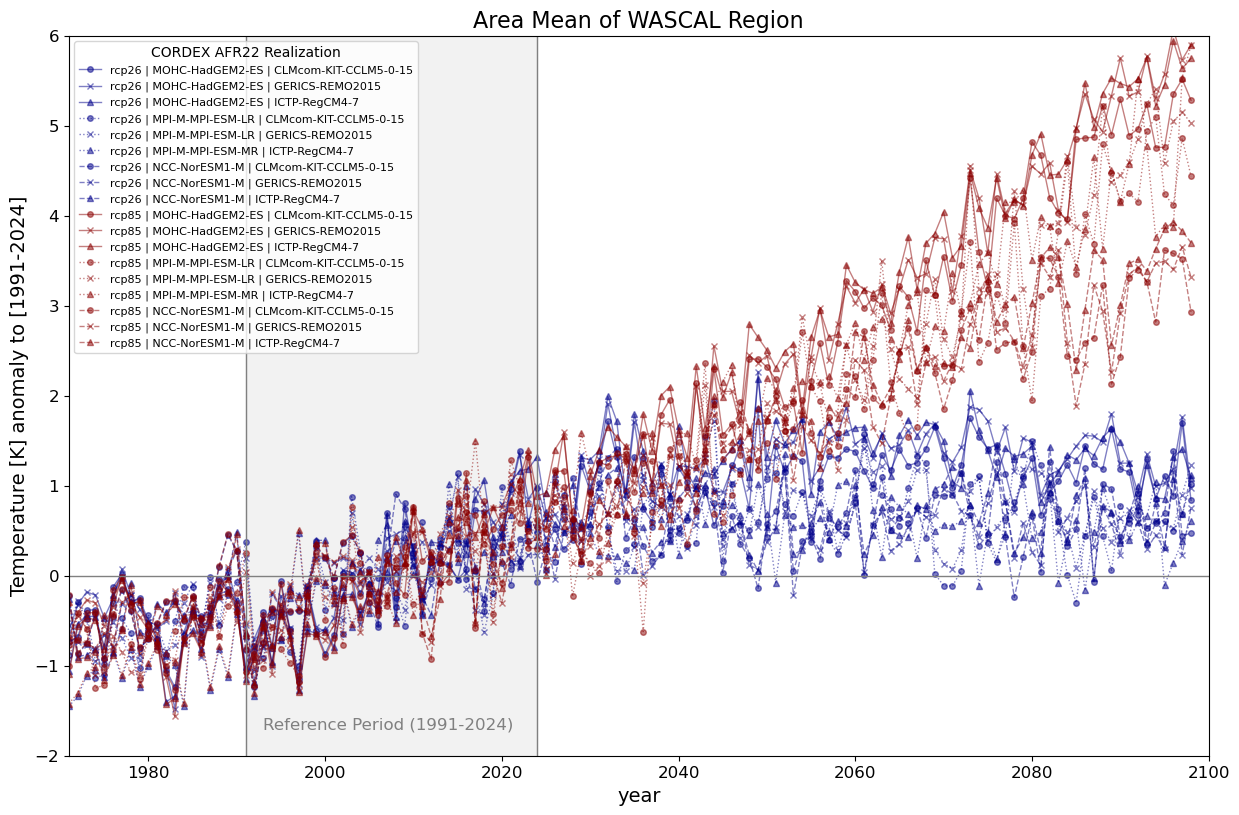

'/work/ch0636/g300047/cicles/timeseries_plots_bulletin'

In [ ]:
# make plot for Anomalies

line_plot_anomaly(df, 'year', 'Temperature [K] anomaly to [1991-2024]', outputpath)
outputpath

In [262]:
# create short realizatin name for heatmap:
df['_RCM'] = df['RCM'].str.split('-').str[1]
df['_RCM'].replace({'KIT': 'CLM'}, inplace=True)
df['_GCM'] = df['GCM'].str.split('-').str[1]
df['_GCM'].replace({'M': 'MPI'}, inplace=True)
#df['_RCM'].unique()
df['realization-short'] = df['_RCM'] + '_' + df['_GCM'] 
df['realization-short'].unique()


/tmp/ipykernel_1015294/1719877775.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['_RCM'].replace({'KIT': 'CLM'}, inplace=True)
/tmp/ipykernel_1015294/1719877775.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

array(['CLM_HadGEM2', 'CLM_MPI', 'CLM_NorESM1', 'REMO2015_HadGEM2',
       'REMO2015_MPI', 'REMO2015_NorESM1', 'RegCM4_MPI', 'RegCM4_NorESM1',
       'RegCM4_HadGEM2'], dtype=object)

In [264]:
# colors for heatmap
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap, Normalize
# Farben - 8 blau und 8 rot
pcmap = ListedColormap(
    [
        "#08306b",
        "#08519c",
        "#2171b5",
        "#4292c6",
        "#6baed6",
        "#9ecae1",
        "#c6dbef",
        "#deebf7",
        "#fee0d2",
        "#fcbba1",
        "#fc9272",
        "#fb6a4a",
        "#ef3b2c",
        "#cb181d",
        "#a50f15",
        "#67000d",
    ]
)
# linearly normalizes data into the [0.0, 1.0] interval
custom_cmap = LinearSegmentedColormap.from_list('custom_map', pcmap.colors, N=14)
#norm = Normalize(vmin=-2, vmax=6)
#custom_colors = rcp85_data["Temperature [K] anomaly to [1991-2024]"].apply(lambda x: custom_cmap(norm([x]))).tolist()

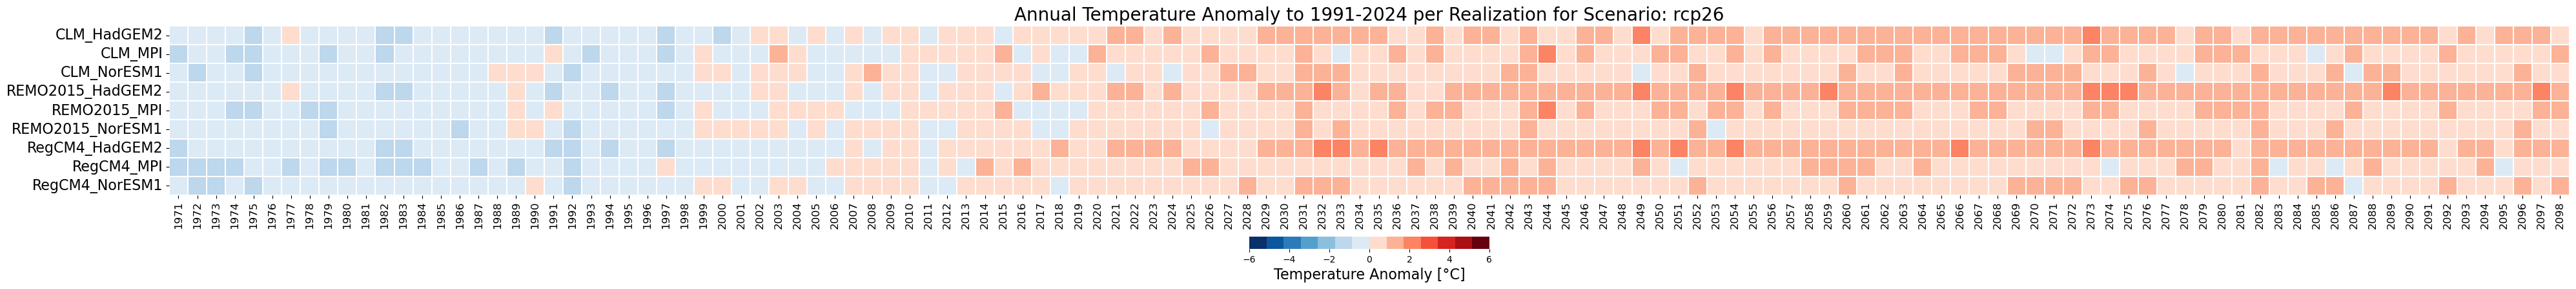

In [278]:
# create heatmap, chose scenario:
sce='rcp26'
#sce='rcp85'
# Filter data for scenario rcp85
rcp85_data = df[df['scenario'] == sce]

# Define normalization for the colormap
#norm = Normalize(vmin=-2, vmax=6)

# Create a custom colormap
#custom_cmap = LinearSegmentedColormap.from_list('custom_map', cmap)


# Pivot the data for heatmap
heatmap_data = rcp85_data.pivot(index='realization-short', columns='year', 
                                values='Temperature [K] anomaly to [1991-2024]')

# Plot the heatmap
plt.figure(figsize=(40, 5))
sns.heatmap(heatmap_data, cmap=custom_cmap, cbar_kws={'shrink':0.1, 'aspect': 20, 
                                                      'label': 'Temperature Anomaly [K] to 1991-2024',
                                                        'orientation': 'horizontal'}, 
                                                        linewidths=0.05, linecolor='white', 
                                                        vmin=-6, vmax=6)
cbar = plt.gcf().axes[-1]

cbar.set_xlabel('Temperature Anomaly [°C]', fontsize=16)

plt.title('Annual Temperature Anomaly to 1991-2024 per Realization for Scenario: '+sce+'', fontsize=20)
#plt.ylabel('Realization', fontsize=16)
plt.ylabel('')
plt.xlabel('')
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
# Save the heatmap
heatmap_outfile = os.path.join(outputpath, 'heatmap_'+sce+'_anomaly.png')
plt.savefig(heatmap_outfile, dpi=300)

plt.show()

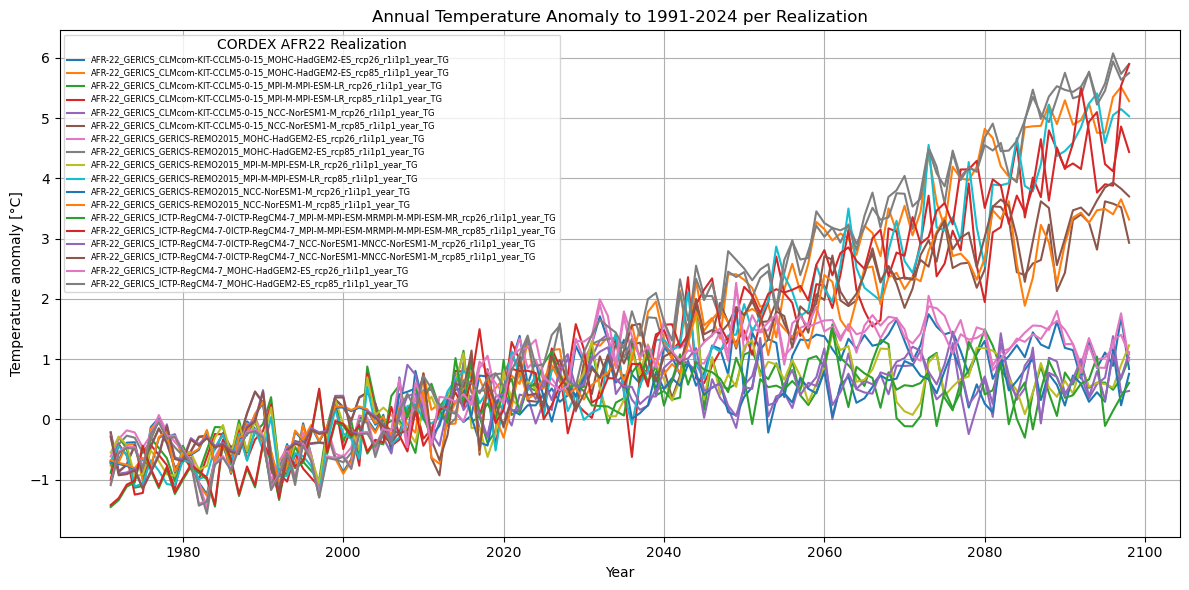

In [272]:
#just for testing, plotting anomalies:
plt.figure(figsize=(12, 6))
for realization, group in df.groupby('realization'):
    plt.plot(
        group['year'],
        group['Temperature [K] anomaly to [1991-2024]'],
        label=realization
    )

plt.xlabel('Year')
plt.ylabel('Temperature anomaly [°C]')
plt.title('Annual Temperature Anomaly to 1991-2024 per Realization')
#plt.title('10-Year Running Mean per Realization')
#plt.legend(title='Realization') #, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(title='CORDEX AFR22 Realization', loc='upper left', ncol=1, fontsize=6)
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
# jetzt mittel über 1991-2024 und dann die anomalien


